In [5]:
#data stuff
import sys
import os
from torch.utils.data import DataLoader
sys.path.append("..")
from tqdm import tqdm
import shutil
import torch
import numpy as np
import pandas as pd

from utils import train_test_split, create_metadata_df
from dataset_xy import CARLADatasetXY
from data_preprocessing import preprocessing
import json
from send2trash import send2trash

# MODEL STUFF
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# GENERAL STUFF
import time
import copy
from tqdm import tqdm

In [6]:
class MyResnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        
        # ResNet Architecture with pretrained weights, also bigger resnets available
        self.net = torchvision.models.resnet18(pretrained=True) # weights=True
        num_ftrs = self.net.fc.in_features

        # Top layer of ResNet which you can modify. We choose Identity to use it as Input for all the heads
        self.net.fc = nn.Identity()
        
        self.cmd_input = nn.Sequential(
            nn.Linear(7, 7),
            nn.LeakyReLU() # TODO
        )
        
        self.spd_input = nn.Sequential(
            nn.Linear(1, 1),
            nn.LeakyReLU() # TODO
        )
        self.thr_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Sigmoid() # [0,1] Range Output
        )
        
        self.brk_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Sigmoid() # [0,1] Range Output
        )
        
        self.str_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Tanh() # [-1,1] Range Output
        )
    def forward(self, rgb, cmd, spd):
        rgb = self.net(rgb) # BRG
        cmd = self.cmd_input(cmd)
        spd = self.spd_input(spd)

        x = torch.cat((rgb, cmd, spd),1)

        #x = self.net.fc(x)
        return self.thr_head(x), self.str_head(x), self.brk_head(x) 

In [7]:
path_data = os.path.join("..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

df_meta_data = pd.read_json("df_meta_data.json")


In [8]:
df_measurements = pd.read_json("df_measurements.json")

Index(['dir', 'speed', 'command', 'steer', 'throttle', 'brake'], dtype='object')
dir         object
speed        int32
command      int32
steer        int32
throttle     int32
brake        int32
dtype: object


array([[<AxesSubplot:title={'center':'speed'}>,
        <AxesSubplot:title={'center':'command'}>],
       [<AxesSubplot:title={'center':'steer'}>,
        <AxesSubplot:title={'center':'throttle'}>],
       [<AxesSubplot:title={'center':'brake'}>, <AxesSubplot:>]],
      dtype=object)

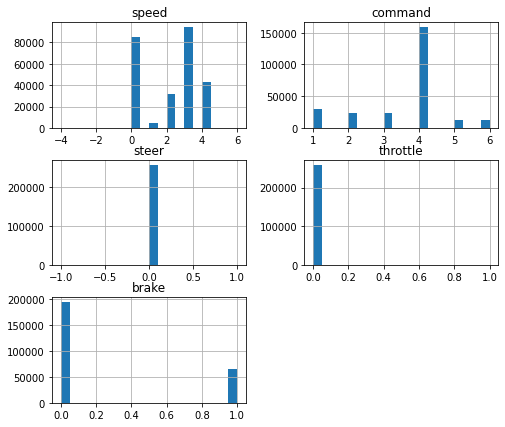

In [10]:
print(df_measurements.keys())
for index in range(1,6):
    df_measurements[df_measurements.keys()[index]] = df_measurements[df_measurements.keys()[index]].astype('int32')
print(df_measurements.dtypes)
df_measurements.hist(figsize=(8, 7), bins=20)


In [11]:

all_measurement_weights_steer =  get_weights_inverse_num_of_samples("steer")
all_measurement_weights_throttle =  get_weights_inverse_num_of_samples("throttle")
all_measurement_weights_brake =  get_weights_inverse_num_of_samples("brake")



def get_weights_inverse_num_of_samples(measurement,bins=10):
    hist, bin_edges = np.histogram(df_measurements[measurement], bins) #ten classes 
    bin_edges[-1] = bin_edges[-1]+0.1
    bin_mapping = np.digitize(df_measurements[measurement], bins=bin_edges,)
    bin_mapping_count = pd.DataFrame(bin_mapping).value_counts(normalize=True).sort_index()
    bin_mapping_weighted = np.zeros(len(bin_mapping))
    for idx, bin_map in enumerate(bin_mapping):
        bin_mapping_weighted[idx] = bin_mapping_count.loc[bin_map]
    bin_mapping_weighted = 1 / bin_mapping_weighted #inverse it
    sample_weights_entire = (bin_mapping_weighted / bin_mapping_weighted.sum())
    print(sample_weights_entire)
    return bin_mapping_weighted

def get_batch_weights(batch_nr):
    sample_weights_batch_steer = (all_measurement_weights_steer[batch_nr*batch_size:(batch_nr+1)*batch_size] /all_measurement_weights_steer[batch_nr*batch_size:(batch_nr+1)*batch_size].sum())
    sample_weights_batch_throttle = (all_measurement_weights_throttle[batch_nr*batch_size:(batch_nr+1)*batch_size] /all_measurement_weights_throttle[batch_nr*batch_size:(batch_nr+1)*batch_size].sum())
    sample_weights_batch_brake = (all_measurement_weights_speed[batch_nr*batch_size:(batch_nr+1)*batch_size] /all_measurement_weights_brake[batch_nr*batch_size:(batch_nr+1)*batch_size].sum())
    return torch.Tensor(sample_weights_batch_speed), torch.Tensor(sample_weights_batch_throttle), torch.Tensor(sample_weights_batch_brake)
    #this should be slower than converting to tensor once and fetching
    #but that takes memory 
    #does it make sense to normalize each batch? Is it not guaranteed 64 frames will have almost same values?
    #then this weighting will only make a difference when both extrema are present in the same batch?
    
#get_weights_inverse_num_of_samples("speed")


[1.17595870e-06 1.17595870e-06 1.17595870e-06 ... 2.34159135e-06
 1.06395429e-06 1.06395429e-06]


array([3.04356927, 3.04356927, 3.04356927, ..., 6.06041306, 2.75368394,
       2.75368394])

In [ ]:
def forward_pass(data, weights):
    # further preprocessing
    steerweight, throttleweight, brakeweight = weights
    X_rgb = torch.squeeze(transform_norm(data["rgb"])).float()
    labels = data["command"]
    # labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
    labels = torch.where(labels == -1, torch.tensor(0, dtype=labels.dtype), labels).to(torch.int64) # Replace by -1 by 0
    # Convert the labels to a one hot encoded tensor
    one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
    X_cmd = torch.squeeze(one_hot).float()
    X_spd = ((data["speed"]-speed_mean)/speed_std).float()
    
    Y_throttle = data["throttle"].float()
    Y_steer = data["steer"].float()
    Y_brake = data["brake"].float()

    # move to GPU
    X_rgb = to_cuda_if_possible(X_rgb)
    X_cmd = to_cuda_if_possible(X_cmd)
    X_spd = to_cuda_if_possible(X_spd)
    
    Y_throttle = to_cuda_if_possible(Y_throttle)
    Y_steer = to_cuda_if_possible(Y_steer)
    Y_brake = to_cuda_if_possible(Y_brake)

    # compute outputs
    optimizer.zero_grad()

    Y_hat = net(X_rgb, X_cmd, X_spd)
    Y_hat_throttle = to_cuda_if_possible(Y_hat[0])
    Y_hat_steer = to_cuda_if_possible(Y_hat[1])
    Y_hat_brake = to_cuda_if_possible(Y_hat[2])

    # get labels from data
    Y_throttle = to_cuda_if_possible(data["throttle"].float())
    Y_steer = to_cuda_if_possible(data["steer"].float())
    Y_brake = to_cuda_if_possible(data["brake"].float())

    # Calculate Loss
    loss_throttle = throttleweight*criterion(Y_hat_throttle, Y_throttle)
    loss_steer = steerweight*criterion(Y_hat_steer, Y_steer)
    loss_brake = brakeweight*criterion(Y_hat_brake, Y_brake)
    loss = sum([loss_throttle, loss_steer, loss_brake])
    return loss

In [ ]:
criterion = nn.L1Loss() # Easy to interpret #nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) #optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
%%time

n_epochs = 10
print_every = 200
valid_loss_min = np.Inf
val_loss = []
train_loss = []
total_step = len(train_dataloader)
validate = False

run = True

for epoch in tqdm(range(1, n_epochs+1)):
    
    running_loss = 0.0
    print(f'Epoch {epoch}\n')
    
    # Work through batches
    for batch_idx, data in enumerate(train_dataloader): #data: (['idx', 'rgb', 'speed', 'steer', 'throttle', 'brake'])
        weights = get_batch_weights(batch_idx)
        loss = forward_pass(data, weights)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        # running_loss += loss.item()
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, 0.0000)) # loss.item()
        
    # Epoch finished, evaluate network and save if network_learned
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f},') # TODO SOLVE NAN ISSUES
    batch_loss = 0

    
    # Evaluation on Test set, skipped for now
    if validate:
        with torch.no_grad():
            net.eval()

            for batch_idx, data in enumerate(test_dataloader):

                loss = forward_pass(data)

                batch_loss += loss.item()
            val_loss.append(batch_loss/len(test_dataloader))
            #network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, \n') # TODO SOLVE NAN ISSUES


            if False:#network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), 'resnet.pt')
                print('Improvement-Detected, save-model')

        # Back to training
        net.train()